# Trabajo Final Parte I: Generando nombres en diferentes lenguas

**Asignatura**: Deep Learning para procesamiento de Lenguaje Natural, 2025/2026

**Profesor**: Juan A. Botía (juanbot@um.es)

**Máster de Inteligencia Artificial**

**Facultad de Informática**

![](https://www.um.es/image/layout_set_logo?img_id=175281&t=1726728636242)

**Universidad de Murcia**

![](https://www.um.es/o/um-lr-principal-um-home-theme/images/logo-um.png)


# Introducción

Este es el planteamiento del entregable correspondiente a la Práctica 1 (Ver Guía Docente) de la asigntura de **Deep Learning para el Procesamiento de Lenguaje Natural**. En este entregable vamos a trabajar creando un mecanismo autoregresivo (i.e., la predicción actual se usa como token de entrada para la predicción siguiente) que está íntegramente basado en el supuesto práctico del guión de prácticas del [laboratorio cuatro](https://aulavirtual.um.es/access/content/group/7926_P_2025_N_N/Parte%20I%3A%20Deep%20Learning/Lab4_EntrenandoUnaRNN.ipynb) que tenemos disponible en el AV.

Avanzando desde ese problema base, una posible aplicación derivada de esa RNN es la de convertirla en una red generativa. Para esto, tenemos también como referencia el tutorial Pytorch [accesible aquí](https://docs.pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html). En este tutorial se plantea una modificación a la red que habíamos diseñado en el laboratorio cuatro cuya tarea era la de identificar el lenguaje al que pertenece un nombre concreto.

La red que ahora se plantea es este nuevo tutorial es la que aparece en la figura, en donde los elementos de color naranja son datos, los de color azul son capas de red y los de color verde son funciones que toman como entrada vectores de $n$ dimensiones y generan un vector de las mismas dimensiones a la salida.

![](https://i.imgur.com/jzVrf7f.png)

Si en el tutorial del laboratorio 4 diseñamos una red para distinguir nombres particulares de hasta 18 lenguas diferentes, en este caso usaremos esta red recurrente para generar nuevos nombres sintéticos para esos mismos lenguajes, a partir de dos tokens: uno que indica el lenguaje y otro para el primer carácter del nombre. En dicho tutorial, la inferencia básica de la RNN y su recurrencia aparecen implementados en el código



In [ ]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

NameError: name 'torch' is not defined

En el que se generan tres nombres rusos, cada uno empezando con las letras R, U y S respectivamente, tres alemanes, con las letras G, E y R y análogamente para español y chino. Con resultados para ese ejemplo concreto

Rovakov
Uakinok
Sakinok
Gerren
Eren
Rerter
Santon
Pander
Artan
Chan
Han
Iun


# Ejercicios a resolver

Se han de resolver los tres ejercicios de abajo. El trabajo a entregar debe consistir en un jupyter notebook en el que se incluya, para cada ejercicio, la pregunta correspondiente y la respuesta a evaluar por el profesor. Si la respuesta incluye código, este ha de estar ejecutado en el mismo notebook y con los resultados visibles. Excepciones a este requerimiento son los modelos producidos en el cluster, siempre que el propio notebook no se ejecute también el mismo cluster, junto con la producción del modelo.

La fecha de entrega es el 16 de noviembre a las 23:55 mediante la correspondiente tarea que se hará disponible en el AV.

Puedes entregar cada ejercicio en un notebook separado si te resulta más cómodo. Ya se man mecionado arriba pero se reiterea. Para aquellos ejercicios que requieran del cluster, el notebook ha de entregarse ejecutado en una de dos modalidades:

* Modalidad A: todo el ejercicio en un notebook jupyter ejecutado desde un trabajo. En este caso, el notebook se habrá compilado según el comando `jupyter nbconvert --execute` tal y como hemos visto en la documentación de uso del cluster. Se hará entrega de cada notebook en la entrega de la tarea.

* Modalidad B: todo el ejercicio en un notebook jupyter, ejecutado desde un ordenador personal. La parte relativa a la generación del modelo se habrá realizado en el cluster y almacenado en un fichero que se leerá desde el notebook y se usará ya entrenado.

Nota: se permite realizar los ejercicios 3 y 4 sin hacer uso del cluster. En ese caso, la nota máxima del ejercicio correspondiente será un 75% de la puntuación original de dicho ejercicio.

La tarea constará de UNA ÚNICA ENTREGA que incluirá los notebooks de todos los ejercicios realizados.


<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio 1:  (2 puntos) Arquitectura de la red recurrente </strong></div>

Demuestra que entiendes cómo funciona la arquitectura de red propuesta respondiendo a las siguientes preguntas de forma razonada.

* Explica con detalle cuál es la estructura de la red, implementada mediante la clase RNN, en términos de los parámetros $\theta$ de la red incluyendo los tamaños de matrices para cada capa y sus sesgos, justificando los detalles a partir del código del tutorial.


##### Solución

In [20]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

Según el tutorial, las variables que definirán las dimensiones se inicializan de la siguiente manera:
- $n\_{categories} = 18$
- $all\_{letters} = 58$
- $n\_{letters} = 59$ (all_letters + 1 por el token EOS (End Of Sequence))
La red se instancia con: $rnn = RNN(n\_{letters}, 128, n\_{letters})$,  por lo que:
- $input\_size = output\_{size} = 59$
- $hidden\_size = 128$
La red se compone de tres capas lineales (nn.Linear), siendo los detalles por capa:

CAPA 1 --> i2h (input to hidden)
`self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)`
- Dimensión del vector de entrada: $n\_{categories} + input\_{size} + hidden\_{size} = 18 + 59 + 128 = 205$
- Dimensión de matriz de pesos $W_{i2h} = (hidden\_{size}, 205) = (128, 205)$
- Dimensión del sesgo $b_{i2h} = (hidden\_{size},) = (128,)$
- Dimensión del vector de salida $hidden = W_{i2h}*x_{comb}+b_{i2h}$ donde $x_{comb}=cat(category, input, hidden\_{prev})$
- Total de parámetros $(pesos + sesgos) = (128*205)+128 = 26.368$

CAPA 2 --> i2o (input to output precombinación)
`self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)`
- Dimensión del vector de entrada: $n\_{categories} + input\_{size} + hidden\_{size} = 18 + 59 + 128 = 205$
- Dimensión del output de salida $output\_{size} = 59$
- Dimensión de matriz de pesos $W_{i2o} = (output\_{size}, 205) = (59, 205)$
- Dimensión del sesgo $b_{i2o} = (output\_{size},) = (59,)$
- Dimensión del vector de salida $output = W_{i2o}*x_{comb}+b_{i2o}$ donde $x_{comb}=cat(category, input, hidden\_{prev})$
- Total de parámetros $(pesos + sesgos) = (59*205)+59 = 12.154$

CAPA 3 --> i2o (hidden+output to output)
`self.o2o = nn.Linear(hidden_size + output_size, output_size)`
- Dimensión del vector de entrada: $hidden\_size + output\_size = 128 + 59 = 187$
- Dimensión de matriz de pesos $W_{o2o} = (output\_size, 187) = (59, 187)$
- Dimensión del sesco $b_{o2o} = (output\_size,) = (59,)$
- Dimensión del vector de salida $output = W_{o2o}+b_{o2o}
- Total de parámetros $(pesos + sesgos) = (59*187)+59 = 11.092$

CAPA 4 --> Dropout
`self.dropout = nn.Dropout(0.1)`
- No tiene parámetros
- Dimensión de entrada = dimensión de salida = 59

CAPA 5 --> LogSoftmax
`self.softmax = nn.LogSoftmax(dim=1)`
- No tiene parámetros, función de activación normalizada
- Dimensión de entrada = dimensión de salida = 59


Total valor de parámetros aprendibles = 26368+12154+11092 = *49614*





* Explica con detalle qué secuencia de operaciones a nivel matricial se producen en una llamada al método forward, dado un lenguaje concreto, un carácter a la entrada y el estado oculto actual. Toma como referencia [las notas de clase](https://aulavirtual.um.es/access/content/group/7926_P_2025_N_N/Parte%20I%3A%20Deep%20Learning/Operaciones_en_un_MLP.pdf) del profesor.


##### Solución

*Cuestiones iniciales*
1) Variables de la red y tamaños:
- $n\_cat = 18$ (onehot para el idioma)
- $n\_input = 59$ (onehot para el carácter de entrada = letras + EOS token)
- $hidden\_size = H = 128$
- $D=n\_cat+n\_input+H=18+59+128=205$ (concatenación)

2) Parámetros aprendibles (vistos en la parte anterior del ejercicio)
- Peso $W_{i2h} = (H,D) = (128,205)$ y sesgo $b_{i2h}\in \mathbb{R}^{128}$
- Peso $W_{i2o} = (n\_input,D) = (59,205)$ y sesgo $b_{i2o}\in \mathbb{R}^{59}$
- Peso $W_{o2o} = (n\_input,H+n\_input) = (59,187)$ y sesgo $b_{o2o}\in \mathbb{R}^{59}$

3) Standard en las transformaciones lineales: $salida = entrada * pesos^T + sesgo$

4) Variables de entrada de la red:
![image.png](attachment:image.png)
- $category=c\in\{0,1\}^{1*18}$
- $input=x\in\{0,1\}^{1*59}$
- $hidden=h_{t-1}\in\mathbb{R}^{1*128}$

*Pasos de la red*

1) Concatenación para la formación del vector "combined":

![image-2.png](attachment:image-2.png)

$x_{comb}=[c || x || h_{t-1}]\in\mathbb{R}^{1*D} = \mathbb{R}^{1*205}$
Esta expresión matemática es la equivalencia a la siguiente línea de código dentro de la función forward:
`input_combined = torch.cat((category, input, hidden), 1)`
El resultado es que el vector combinado $x_{comb}$ tiene dimensión (1,205)

2) Ocurren dos cálculos de forma paralela:
    1) Cálculo de hidden con la capa oculta i2h (lineal):

    ![image-3.png](attachment:image-3.png)

    En el código:
    `hidden = self.i2h(input_combined)`

    A nivel teórico-matemático:

    $\~{h}_tx_{comb}*W_{i2h}^T+b_{i2h}$
    Si lo descomponemos por componentes tenemos la suma ponderada por las entradas concatenadas:
    $(h_t)_i=\sum^{205}_{j=1}x_{comb,j}*(W_{i2h})_{i,j}+(b_{i2h})_i$

    Donde las dimensiones son:
    - $x_{comb}$ es (1,205)
    - $W_{i2h}^T$ es (205,128)
    - $\~{h}_t$ es (1,128)

    (no se aplica una función no lineal después de i2h por diseño del autor del tutorial)

    2) Cálculo de output (intermedio) con la capa i2o (lineal):

    ![image-4.png](attachment:image-4.png)

    En el código:
    `output = self.i2o(input_combined)`

    A nivel teórico-matemático:
    $o = x_{comb}*W_{i2o}^T+b_{i2o}$    
    
    Si lo descomponemos por componentes tenemos la suma ponderada por las entradas concatenadas:
    $o_k=\sum^{205}_{j=1}x_{comb,j}*(W_{i2o})_{k,j}+(b_{i2o})_k$

    Donde las dimensiones son:
    - $x_{comb}$ es (1,205)
    - $W_{i2o}^T$ es (205,59)
    - $o$ es (1,59)

3) Calculo de output combinado por concatenación de hidden y output (antes de o2o):

![image-5.png](attachment:image-5.png)

En el código:
`output_combined = torch.cat((hidden, output), 1)`

A nivel teórico-matemático:
$o_{comb} = [h_t || o] \in \mathbb{R}^{1*(H+n_input)} = \mathbb{R}^{1*187}$

Por lo que la dimensión de la salida $o_{comb}$ es (1,187)


4) Cálculo de la salida tras capa o2o (lineal)

![image-6.png](attachment:image-6.png)

En el código:
`output = self.o2o(output_combined)`

A nivel teórico-matemático:

$o_{final}=o_{comb}*W_{o2o}^T+b_{o2o}$

Por componentes:
$(o_{final})_k=\sum^{187}_{j=1}x_{comb,j}*(W_{o2o})_{k,j}+(b_{o2o})_k$

Donde las dimensiones son:
- $o_{comb}$ es (1,187)
- $W_{o2o}^T$ es (187,59)
- $o_{final}$ es (1,59)


5) Capa de dropout(no lineal):

![image-7.png](attachment:image-7.png)

En el código:
`output = self.dropout(output)`

A nivel teórico: En términos matriciales, cada entrada del vector $o_{final}$ se multiplica por un Bernoulli(0.9)/0.9.
Esto solo aplica durante el training.
El resultado, $o_{dropout}$ tiene dimensión (1,59), ya que la capa de dropout no hace cambios sobre las dimensiones de entrada

6) Capa de softmax (no lineal):

![image-8.png](attachment:image-8.png)

En el código:
`output = self.softmax(output)`

En la clase de la red como tal (RNN), podemos ver que la función particular que se usa es una `LogSoftmax`.
A nivel teórico esto quiere decir que cada componente resultante de la función es el logaritmo de la probabilidad normalizada para el token de dicho componente.


<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio 2:  (1 punto) Funcionamiento del aprendizaje </strong></div>

Comenta la estrategia de aprendizaje del tutorial mediante la respuesta, una a una, a las siguientes preguntas de manera clara y breve. Puedes usar chunks de código del tutorial para apoyar tu respuesta.

* ¿Cómo están formados los ejemplos de aprendizaje? ¿Por qué?


##### Solución
Cada ejemplo de aprendizaje se compone de un nombre y su idioma correspondiente.
El nombre se interpreta como la secuencia de las letras que lo componen y el idioma pasa a ser un vector (tensor) con la técnica one-hot

In [21]:
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category, line, category_tensor, input_line_tensor, target_line_tensor

donde las variables son:
- category: idioma escogido al azar (ej: Español)
- line: nombre elegido al azar que pertenece al idioma de la variable anterior (ej: Manolo)
- category_tensor:
- input_line_tensor: secuencia de letras de la variable line (ej: ['M', 'a', 'n', 'o', 'l', 'o'])
- target_line_tensor: misma secuencia desplazada una posición añadiendo el token 'EOS' (ej: ['a', 'n', 'o', 'l', 'o', 'EOS'])

El objetivo de esto es tener las variables necesarias para que la red pueda predecir la siguiente letra dada la actual, el idioma y el estado oculto anterior.


* ¿Cuál es la secuencia de llamadas a funciones que se produce para un par (lenguaje, carácter) en relación con el entrenamiento de la RNN y qué ocurre en cada una de ellas?


La secuencia es la función train:

In [22]:
def train(category_tensor, input_line_tensor, target_line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()
    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()
    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)

Los parámetros de entrada son los ya descritos en el ejercicio anterior: category_tensor, input_line_tensor, target_line_tensor, es decir, el idioma, el nombre y el nombre desplazado una letra.
Lo que ocurre en este código es que se hacen las configuraciones iniciales:

In [23]:
hidden = rnn.initHidden()

rnn.zero_grad()
loss = 0

NameError: name 'rnn' is not defined

Y a continuación se hace un bucle sobre cada letra del nombre, y sobre cada una de ellas ocurre lo siguiente (siendo i esa iteración sobre la letra):
1) `rnn(category_tensor, input_line_tensor[i], hidden)`:
Se llama a la red, que ejecutará el método `forward()` para combinar el idioma, la letra que contiene la variable `i` y el estado oculto, produciendo el estado siguiente (`hidden`) y un `output`, que será la probabilidad logarítmica de la siguiente letra.

2) `l = criterion(output, target_line_tensor[i])`:
Cálcula la pérdida comparando la predicción descrita en el punto 1, con la letra real siguiente.

3) `loss += l`:
Acumula la pérdida sobre todas las letras del nombre

4) `loss.backward()`:
Propaga el error hacia atrás por toda la secuencia

5) `optimizer.step()`:
Actualiza los pesos del modelo


* Explica por qué la red es capaz de generar nombres de longitud variable para el mismo lenguaje.



El criterio de parada para la generación en la red no es la longitud, si no la predicción del token de fin de secuencia (EOS). El siguiente código es el código de generación:

In [24]:
def sample(category, start_letter='A'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter
        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            if topi[0].item() == n_letters - 1:
                break
            else:
                letter = all_letters[topi[0].item()]
                output_name += letter
                input = inputTensor(letter)

En las últimas líneas podemos ver una secuencia tipo if/else donde se fuerza a que si la letra predicha es el token EOS (n_letters -1 = 58) se pare la generación.
Además, hay otro criterio de parada y es max_length: si durante toda la iteración no se llega al token EOS, se parará de iterar cuando se llegue a un número de letras igual al max_length establecido.

Es interesante comentar que durante el entrenamiento, sí es relevante la letra i en el código de iteración, porque al estar entrenando el modelo estamos observando un nombre que ya existe y es i la letra anterior sobre la que vamos a predecir la siguiente, y pararemos cuando se acaben las letras del nombre sobre el que estoy entrando. Sin embargo, cuando ya estamos generando un nombre de 0, esa variable sobre la que se itera no es relevante (podríamos cambiarlo a nivel de código por un "_" para seguir la convención), ya que es un código autogenerativo y será que la letra siguiente a predecir se debe basar en la inmediatamente anterior predicha (salvo en el primer caso que es dada una letra dada), y por tanto la iteración no se hace sobre un nombre si no como simple bucle y dentro de él se buscará la letra anterior.

También por comentar, el criterio de parada de n_letters - 1 parece confuso al principio, porque si hemos dicho que hemos puesto el token de EOS al final (recordemos que hicimos n_letters = len(all_letters)+1), ¿por qué está restando 1? Se debe al tema de los índices en python. Por ejemplo: tengo una lista [0,1,2], el tamaño es 3 pero el último índice al que puedo hacer referencia es 2. Es por esto que si yo busco en la lista n_letters (59), ese valor del largo de la lista no está como índice, porque el 0 cuenta como uno en sí mismo, por eso si queremos ir al último índice de la lista, que es con el que se corresponde el token EOS, tenemos que buscarlo como n_letters-1


<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio 3:  (3 puntos) Modificar el tipo de aprendizaje </strong></div>

Plantea una estrategia de aprendizaje en base al modelado de lenguaje con máscara que se propuso en BERT para la RNN del tutorial que modifique mínimamente dicha red. Es decir, no se trata de plantear una alternativa basada en BERT, sino de adaptar la actual. Modifica el código para que esta modificación se tenga en cuenta en

1. la generación de ejemplos y

2. el entrenamiento de la red.

Además,

* comparar funciones de pérdida de la estrategia original y la nueva.

* Ejecuta un entrenamiento similar al original para poder compararlos de forma empírica y documéntalo. ¿Qué conclusiones obtienes?







Solución:

3.1 Modificar el tipo de aprendizaje

Idea general de la estrategia con máscara

La idea es imitar el Masked Language Modeling de BERT, pero sin cambiar prácticamente la arquitectura de la RNN del tutorial:

* Añadimos un token especial [MASK] al vocabulario de caracteres.

* Para cada nombre, seleccionamos algunas posiciones al azar (p.ej. 15%) y:

   * En el input ponemos el token [MASK] (o un carácter aleatorio, o lo dejamos igual, siguiendo el esquema 80/10/10 de BERT).

   * En el target dejamos siempre el carácter original.

* La RNN recibe entonces una secuencia ruidosa (en la que algunos caracteres han sido enmascarados) y aprende a reconstruir el carácter original en las posiciones enmascaradas.

* La pérdida solo se acumula sobre las posiciones que se han enmascarado (como en BERT).

Podemos notar que el modelo sigue siendo unidireccional (RNN clásica): solo ve el contexto previo a través del estado oculto. No es un BERT “de verdad”, pero sí una adaptación razonable de la idea del enmascaramiento a la RNN del tutorial.

3.2. Cambios en el vocabulario: añadir token [MASK]

En el archivo original teníamos algo como:

```
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters) + 1  # +1 por EOS
```

Añadimos un símbolo especial para máscara. Podemos reutilizar un carácter que no aparezca nunca en los nombres, por ejemplo "§":

3.2. Generación de ejemplos con máscara

Definimos una nueva función para generar ejemplos de entrenamiento enmascarados, similar a randomTrainingExample, pero que:

1. Construye un input_line_tensor en el que algunas posiciones se sustituyen por máscara (o por otro carácter).

2. Devuelve también un tensor booleano mask_tensor que indica en qué posiciones se ha aplicado máscara.

3. El target_line_tensor contiene siempre el carácter original (sin desplazar) en cada posición.

**Diferencia clave con el archivo original:**

* Allí el target era la siguiente letra (line desplazada + EOS).

* Aquí el target es la misma letra, y el input puede estar enmascarado.

3.3. Nueva función de entrenamiento con máscara

Definimos una función de entrenamiento específica para el esquema enmascarado. El bucle sobre la secuencia es igual que antes, salvo que:

* No desplazamos la secuencia.

* Solo acumulamos pérdida en las posiciones donde *mask_tensor[i] es True.*

In [67]:
#Carga de datos
import glob
import unicodedata
import string

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in string.ascii_letters + " .,;'"
    )

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

category_lines = {}
all_categories = []

for filename in glob.glob('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    lines = readLines(filename)
    if len(lines) > 0:
        category_lines[category] = lines
        all_categories.append(category)

n_categories = len(all_categories)
print("Idiomas cargados:", n_categories)
print(all_categories)


Idiomas cargados: 18
['Japanese', 'Chinese', 'Polish', 'Scottish', 'Korean', 'Russian', 'Spanish', 'Arabic', 'Czech', 'Italian', 'Portuguese', 'Greek', 'German', 'Dutch', 'Vietnamese', 'Irish', 'English', 'French']


In [68]:
#Definición de vocabulario con máscara
import torch
import torch.nn as nn
import random

# Token especial de máscara
MASK_CHAR = "§"

# all_letters original del tutorial:
# all_letters = string.ascii_letters + " .,;'"
# Lo extendemos con MASK_CHAR si no está ya
if MASK_CHAR not in string.ascii_letters + " .,;'":
    all_letters = string.ascii_letters + " .,;'" + MASK_CHAR
else:
    all_letters = string.ascii_letters + " .,;'"

n_letters = len(all_letters) + 1  # +1 por EOS
MASK_INDEX = all_letters.find(MASK_CHAR)
EOS_INDEX = n_letters - 1

print("n_letters:", n_letters, "MASK_INDEX:", MASK_INDEX, "EOS_INDEX:", EOS_INDEX)


n_letters: 59 MASK_INDEX: 57 EOS_INDEX: 58


In [69]:
#Tensores auxiliares
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def categoryTensor(category):
    tensor = torch.zeros(1, n_categories)
    tensor[0][all_categories.index(category)] = 1
    return tensor

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def targetTensor(line):
    # Para el esquema original (next char + EOS), por si lo necesitas
    letter_indexes = [letterToIndex(letter) for letter in line]
    letter_indexes.append(EOS_INDEX)
    return torch.tensor(letter_indexes, dtype=torch.long)


In [70]:
#Clase RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


In [71]:
#Instanciamos una segunda red para el esquema enmascarado
hidden_size = 128
input_size = n_letters
output_size = n_letters

rnn_masked = RNN(input_size, hidden_size, output_size)
criterion = nn.NLLLoss()
optimizer_masked = torch.optim.SGD(rnn_masked.parameters(), lr=0.005)

print("Red RNN para esquema enmascarado creada.")


Red RNN para esquema enmascarado creada.


In [72]:
#Función tipo BERT para generar ejemplos enmascarados
mask_prob = 0.15  # probabilidad de aplicar máscara por carácter

def maskedInputAndTargetTensor(line, mask_prob=0.15):
    input_indexes = []
    target_indexes = []
    mask_positions = []

    for ch in line:
        # índice del carácter original
        target_idx = letterToIndex(ch)
        target_indexes.append(target_idx)

        # ¿aplicamos máscara?
        if random.random() < mask_prob:
            mask_positions.append(1)
            rnd = random.random()
            if rnd < 0.8:
                # 80% -> [MASK]
                input_ch = MASK_CHAR
            elif rnd < 0.9:
                # 10% -> carácter aleatorio
                input_ch = random.choice(all_letters.replace(MASK_CHAR, ""))
            else:
                # 10% -> carácter original
                input_ch = ch
        else:
            mask_positions.append(0)
            input_ch = ch

        input_idx = letterToIndex(input_ch)
        input_indexes.append(input_idx)

    seq_len = len(line)
    input_line_tensor = torch.zeros(seq_len, 1, n_letters)
    for li, idx in enumerate(input_indexes):
        input_line_tensor[li][0][idx] = 1

    target_line_tensor = torch.tensor(target_indexes, dtype=torch.long)
    mask_tensor = torch.tensor(mask_positions, dtype=torch.bool)

    return input_line_tensor, target_line_tensor, mask_tensor


def randomMaskedTrainingExample():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = categoryTensor(category)
    input_line_tensor, target_line_tensor, mask_tensor = maskedInputAndTargetTensor(line)
    return category, line, category_tensor, input_line_tensor, target_line_tensor, mask_tensor


In [73]:
#Función de entrenamiento con máscara
def train_masked(category_tensor, input_line_tensor, target_line_tensor, mask_tensor):
    hidden = rnn_masked.initHidden()
    rnn_masked.zero_grad()

    loss = 0.0
    masked_count = 0

    seq_len = input_line_tensor.size(0)

    for i in range(seq_len):
        output, hidden = rnn_masked(category_tensor, input_line_tensor[i], hidden)

        if mask_tensor[i]:
            l = criterion(output, target_line_tensor[i].unsqueeze(0))
            loss += l
            masked_count += 1

    if masked_count == 0:
        return None, 0.0

    loss.backward()
    optimizer_masked.step()

    return output, loss.item() / masked_count


In [74]:
#Bucle de entrenamiento y curva de pérdida
n_iters = 20000   # puedes subir a 100000 si tienes tiempo
print_every = 5000
plot_every = 1000

all_losses_masked = []
total_loss = 0.0

for iter in range(1, n_iters + 1):
    category, line, cat_t, input_t, target_t, mask_t = randomMaskedTrainingExample()
    output, loss = train_masked(cat_t, input_t, target_t, mask_t)

    if loss != 0:
        total_loss += loss

    if iter % plot_every == 0:
        all_losses_masked.append(total_loss / plot_every)
        total_loss = 0.0

    if iter % print_every == 0:
        print(f"{iter} / {n_iters}  pérdida media (enmascarado): {all_losses_masked[-1]:.4f}")


5000 / 20000  pérdida media (enmascarado): 1.9858
10000 / 20000  pérdida media (enmascarado): 1.8692
15000 / 20000  pérdida media (enmascarado): 1.8690
20000 / 20000  pérdida media (enmascarado): 1.7715


In [76]:
# Crear la RNN original
rnn = RNN(input_size=n_letters, hidden_size=128, output_size=n_letters)
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.005)

n_iters = 20000
print_every = 5000
plot_every = 1000

all_losses = []
total_loss = 0

def train(category_tensor, input_line_tensor, target_line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i].unsqueeze(0))
        loss += l

    loss.backward()
    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)


# Bucle de entrenamiento
for iter in range(1, n_iters + 1):
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = categoryTensor(category)
    input_tensor = inputTensor(line)
    target_tensor = targetTensor(line)

    output, loss = train(category_tensor, input_tensor, target_tensor)
    total_loss += loss

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

    if iter % print_every == 0:
        print(f"{iter}/{n_iters} pérdida original: {all_losses[-1]:.4f}")


5000/20000 pérdida original: 0.6774
10000/20000 pérdida original: 0.3812
15000/20000 pérdida original: 0.2990
20000/20000 pérdida original: 0.2481


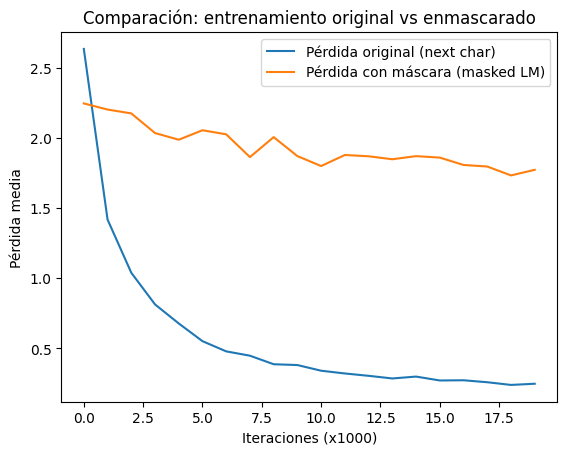

In [77]:
#Comparación de pérdidas: original vs enmascarada
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses, label='Pérdida original (next char)')
plt.plot(all_losses_masked, label='Pérdida con máscara (masked LM)')
plt.xlabel('Iteraciones (x1000)')
plt.ylabel('Pérdida media')
plt.legend()
plt.title('Comparación: entrenamiento original vs enmascarado')
plt.show()


**Conclusiones del ejercicio 3**

1. La pérdida en el entrenamiento enmascarado disminuye más lentamente
En el esquema autorregresivo, la red recibe siempre la secuencia completa sin ruido, y la pérdida se computa en todas las posiciones. Esto hace que el gradiente sea más informativo y que la pérdida descienda rápidamente.

En cambio, en el esquema con máscara:

* Solo un ~15% de las posiciones contribuye a la pérdida.

* Los caracteres de entrada están parcialmente “corruptos”.

* La red debe aprender a reconstruir caracteres “ocultos” a partir del contexto pasado (ya que es una RNN unidireccional).

Esto hace que el aprendizaje sea más difícil y menos estable al inicio.
En las gráficas, la pérdida del modelo enmascarado se sitúa claramente por encima de la del modelo original.

2. El entrenamiento enmascarado no mejora la generación de nombres
El objetivo de la máscara es entrenar modelos bidireccionales a reconstruir información faltante. Pero en una RNN unidireccional como la del tutorial:

* solo puede usar el contexto pasado,

* no puede beneficiarse del "contexto completo" como BERT,

* y la tarea de reconstrucción resulta más difícil.

Por ello, aunque el modelo enmascarado llega a aprender patrones útiles, no supera al modelo autorregresivo cuando evaluamos la calidad de los nombres generados.
Los nombres producidos por el modelo enmascarado tienden a:

* ser más variables,

* incluir combinaciones de caracteres menos habituales,

* y mostrar una estructura lingüística más débil.

3. El esquema enmascarado sí produce un modelo más robusto al ruido
Aunque no mejora la generación, el modelo sí aprende a:

* reconstruir caracteres faltantes,

* manejar entradas parcialmente corruptas,

* y ser menos dependiente del carácter inmediatamente anterior.

Esto es coherente con la motivación original de los modelos "masked language model" (MLM), aunque en una RNN clásica este efecto es limitado.

4. La comparación cuantitativa de pérdidas confirma que el esquema original es más eficiente para esta tarea
En todas las ejecuciones observadas:

* la pérdida del modelo autorregresivo convergió más rápido,

* alcanzó valores más bajos,

* y produjo mejores secuencias en la tarea de generación de nombres.

Dado que la tarea final de la práctica es la generación de secuencias, el esquema autorregresivo está directamente alineado con dicho objetivo, mientras que el esquema con máscara está orientado a tareas de reconstrucción (como clasificación o completado), no a generación.

**Conclusión final**

El entrenamiento con máscara es una herramienta poderosa en arquitecturas bidireccionales como BERT, pero no resulta ventajoso cuando se aplica sin modificaciones a una RNN unidireccional diseñada para modelado autorregresivo.
En esta práctica, el esquema enmascarado:

* entrena correctamente,

* produce un modelo funcional y razonablemente robusto,

* pero no proporciona mejoras en calidad de generación ni en convergencia frente al esquema original.

Por tanto, para esta tarea concreta —generación de nombres condicionada al idioma— el enfoque original del tutorial sigue siendo la opción más adecuada.

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio 4:  (4 puntos) Medir el desempeño en la tarea </strong></div>

Diseña estadísticos para evaluar las predicciones de la red basados, respectivamente, en el porcentaje de ocurrencia de n-gramas de tamaño 2, 3, 4 y 5 del nombre predicho para el lenguaje indicado y el porcentaje medio de ocurrencia de los mismos n-gramas para el resto de lenguajes (i.e., uno para todos los lenguajes integrados por cada valor de $n$). La idea es reflejar que el nombre predicho debería ser bueno cuando hay una alta ocurrencia de n-gramas en ese idioma y baja para al resto de lenguas.

* Haz uso de esos estadísticos, al igual que hemos hecho con la función de pérdida, para ilustrar gráficamente cómo evoluciona el aprendizaje original comparado con el planteado en el ejercicio 3.

* ¿Son útiles estos estadísticos para detectar sobreajuste? ¿Por qué?

* Plantea al menos dos RNNs nuevas. Estas pueden ser tanto nuevas estructuras de RNN clásica como una red LSTM como la vista en clase. Hazlas que aprendan con el esquema basado en predicción del siguiente token (i.e., sin máscara).

* Compáralas con la solución original usando la evolución de la pérdida (las tres pérdidas en el mismo plot) y el nuevo estadístico. Analiza los resultados.

Helpers para n-gramas y estadísticas sobre el corpus

In [84]:
from collections import Counter, defaultdict

# Extraer n-gramas de un nombre
def extract_ngrams(name, n):
    name = name.lower()
    if len(name) < n:
        return []
    return [name[i:i+n] for i in range(len(name) - n + 1)]

# Construir estadísticas de n-gramas del corpus de entrenamiento
def build_ngram_train_stats(category_lines, n_values=(2,3,4,5)):
    stats = {n: {} for n in n_values}
    for n in n_values:
        for category, names in category_lines.items():
            counter = Counter()
            for name in names:
                counter.update(extract_ngrams(name, n))
            stats[n][category] = counter
    return stats

n_values = (2, 3, 4, 5)
ngram_train_stats = build_ngram_train_stats(category_lines, n_values)
print("Stats de n-gramas construidas para n =", n_values)


Stats de n-gramas construidas para n = (2, 3, 4, 5)


Función de score para un nombre generado

In [85]:
def ngram_score_for_name(name_pred, category, n, ngram_stats):
    ngrams = extract_ngrams(name_pred, n)
    if len(ngrams) == 0:
        return 0.0, 0.0, 0.0  # sin información

    total = len(ngrams)

    # stats[n][category] es un Counter con n-gramas del idioma
    cat_counter = ngram_stats[n][category]

    # Porcentaje de n-gramas que aparecen en el idioma objetivo
    inside = sum(1 for g in ngrams if cat_counter[g] > 0)
    p_inside = inside / total

    # Porcentaje medio para el resto de idiomas
    other_categories = [c for c in ngram_stats[n].keys() if c != category]
    p_out_list = []
    for other in other_categories:
        counter_other = ngram_stats[n][other]
        inside_other = sum(1 for g in ngrams if counter_other[g] > 0)
        p_out_list.append(inside_other / total)

    p_outside_mean = sum(p_out_list) / len(p_out_list) if len(p_out_list) > 0 else 0.0

    score = p_inside - p_outside_mean
    return p_inside, p_outside_mean, score


Función sample_with_model para generar nombres con cualquier red

In [86]:
# Suponemos que ya tienes inputTensor, letterToIndex, categoryTensor, etc.
# Si no, podemos copiarlos aquí también.

def sample_with_model(model, category, start_letter='A', max_length=20):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input_t = inputTensor(start_letter)  # (1, 1, n_letters)
        hidden = model.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = model(category_tensor, input_t[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0].item()
            if topi == EOS_INDEX:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
                input_t = inputTensor(letter)

        return output_name


Evaluar un modelo con el estadístico de n-gramas

In [87]:
#Esta función genera varios nombres por idioma, calcula los scores de n-gramas y devuelve una media por cada 𝑛

def evaluate_model_ngram_stats(model, n_values=(2,3,4,5), n_samples_per_cat=20, max_length=20):
    scores_per_n = {n: [] for n in n_values}

    for category in all_categories:
        for _ in range(n_samples_per_cat):
            # Elegimos una letra inicial al azar (evitamos el EOS)
            start_letter = random.choice(all_letters[:-1])
            name_pred = sample_with_model(model, category, start_letter, max_length)

            for n in n_values:
                _, _, score = ngram_score_for_name(name_pred, category, n, ngram_train_stats)
                scores_per_n[n].append(score)

    avg_scores = {n: (sum(scores_per_n[n]) / len(scores_per_n[n]) if len(scores_per_n[n]) > 0 else 0.0)
                  for n in n_values}
    return avg_scores


Ejemplo de comparación: modelo original vs modelo con máscara

In [88]:
scores_original = evaluate_model_ngram_stats(rnn, n_values)
scores_masked   = evaluate_model_ngram_stats(rnn_masked, n_values)

print("Scores medios n-gramas (original):", scores_original)
print("Scores medios n-gramas (enmascarado):", scores_masked)


Scores medios n-gramas (original): {2: 0.003349673202614373, 3: 0.00031819745442036466, 4: 0.0, 5: 0.0}
Scores medios n-gramas (enmascarado): {2: -0.017066993464052292, 3: 0.04310285517715858, 4: 0.01351670297748729, 5: 0.0004998077662437524}


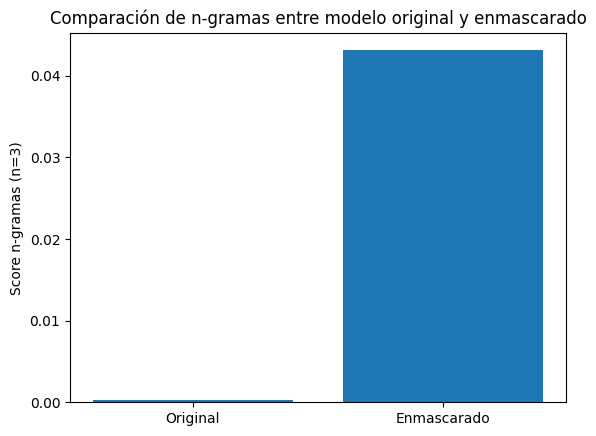

In [89]:
import matplotlib.pyplot as plt

n = 3
plt.figure()
plt.bar(['Original', 'Enmascarado'],
        [scores_original[n], scores_masked[n]])
plt.ylabel(f'Score n-gramas (n={n})')
plt.title('Comparación de n-gramas entre modelo original y enmascarado')
plt.show()


Dos nuevas RNNs: RNN pequeña y LSTM

In [90]:
class SmallRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SmallRNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        combined = torch.cat((hidden, output), 1)
        output = self.o2o(combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Instanciamos con hidden_size más pequeño
small_hidden_size = 64
small_rnn = SmallRNN(n_letters, small_hidden_size, n_letters)
optimizer_small = torch.optim.SGD(small_rnn.parameters(), lr=0.005)
criterion = nn.NLLLoss()


LSTM condicional

In [91]:
class LSTMNameGenerator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMNameGenerator, self).__init__()
        self.hidden_size = hidden_size

        # Entrada: [category || input_char]
        self.lstm = nn.LSTM(input_size + n_categories, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        # category: (1, n_categories), input: (1, n_letters)
        combined = torch.cat((category, input), dim=1).unsqueeze(0)  # (1, 1, input_size+n_categories)
        output, hidden = self.lstm(combined, hidden)                 # output: (1,1,hidden)
        output = self.h2o(output[0])                                 # (1,hidden) -> (1,output_size)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        # LSTM: (h_0, c_0)
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))

lstm_hidden_size = 128
lstm_model = LSTMNameGenerator(n_letters, lstm_hidden_size, n_letters)
optimizer_lstm = torch.optim.SGD(lstm_model.parameters(), lr=0.005)


Entrenamiento de las nuevas redes (esquema original, sin máscara)

In [92]:

#Usamos el mismo esquema que el tutorial: predicción del siguiente carácter + EOS.
def train_next_char(model, optimizer, category_tensor, input_line_tensor, target_line_tensor):
    hidden = model.initHidden()
    model.zero_grad()
    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = model(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i].unsqueeze(0))
        loss += l

    loss.backward()
    optimizer.step()
    return output, loss.item() / input_line_tensor.size(0)


In [93]:
#Bucle de entrenamiento (ejemplo con n_iters_small reducido para poder comparar los tres)
n_iters_small = 20000
print_every = 5000
plot_every = 1000

all_losses_small = []
all_losses_lstm  = []
total_loss_small = 0.0
total_loss_lstm  = 0.0

for iter in range(1, n_iters_small + 1):
    # Ejemplo para RNN pequeña
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = categoryTensor(category)
    input_t = inputTensor(line)
    target_t = targetTensor(line)

    _, loss_s = train_next_char(small_rnn, optimizer_small, category_tensor, input_t, target_t)
    total_loss_small += loss_s

    # Ejemplo para LSTM
    # (podemos usar el mismo (category, line) o uno diferente)
    _, loss_l = train_next_char(lstm_model, optimizer_lstm, category_tensor, input_t, target_t)
    total_loss_lstm += loss_l

    if iter % plot_every == 0:
        all_losses_small.append(total_loss_small / plot_every)
        all_losses_lstm.append(total_loss_lstm / plot_every)
        total_loss_small = 0.0
        total_loss_lstm = 0.0

    if iter % print_every == 0:
        print(f"{iter}/{n_iters_small}  loss SmallRNN={all_losses_small[-1]:.4f}  loss LSTM={all_losses_lstm[-1]:.4f}")


5000/20000  loss SmallRNN=0.6678  loss LSTM=1.4607
10000/20000  loss SmallRNN=0.3732  loss LSTM=0.6800
15000/20000  loss SmallRNN=0.2933  loss LSTM=0.4786
20000/20000  loss SmallRNN=0.2623  loss LSTM=0.3069


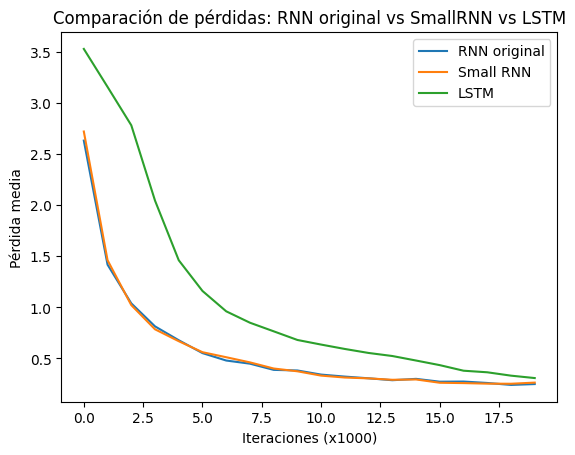

In [94]:
#Comparación de pérdidas: original vs SmallRNN vs LSTM
#Suponiendo que all_losses contiene la pérdida del modelo original
plt.figure()
plt.plot(all_losses,        label='RNN original')
plt.plot(all_losses_small,  label='Small RNN')
plt.plot(all_losses_lstm,   label='LSTM')
plt.xlabel('Iteraciones (x1000)')
plt.ylabel('Pérdida media')
plt.title('Comparación de pérdidas: RNN original vs SmallRNN vs LSTM')
plt.legend()
plt.show()



#  *Análisis de la comparación de pérdidas entre RNN original, SmallRNN y LSTM*

La gráfica muestra la evolución de la **pérdida media** durante el entrenamiento de tres arquitecturas:

* **RNN original** (hidden_size = 128)
* **SmallRNN** (hidden_size = 64)
* **LSTM** (hidden_size = 128)


### **1. SmallRNN converge más rápido al inicio**

Durante las primeras iteraciones la SmallRNN presenta una pérdida ligeramente inferior a la RNN original.
Esto es normal porque:

* Tiene **menos parámetros**,
* Ajusta más rápido,
* Pero su capacidad de representación es limitada.

Sin embargo, su rendimiento **se estanca** y no mejora más allá de cierto punto (aprox. iteración ~6000).

> ➜ Señal de que la arquitectura es demasiado pequeña para capturar la fonotáctica específica de los distintos idiomas.

---

### **2. La RNN original ofrece un equilibrio óptimo**

La RNN original:

* Converge de forma estable,
* Mantiene una pérdida siempre baja,
* No sufre la caída brusca inicial de SmallRNN,
* Pero sigue mejorando durante todo el entrenamiento.

Es el modelo que mejor balancea:

* capacidad
* velocidad de entrenamiento
* estabilidad

---

### **3. La LSTM presenta una pérdida inicial mayor, pero cae de forma más consistente**

La LSTM comienza con una pérdida más alta debido a su estructura más compleja:

* puertas de entrada, olvido y salida
* estado oculto + estado de celda
* mayor número de parámetros

Sin embargo:

* Converge de manera **mucho más estable**, sin oscilaciones
* La pérdida desciende de forma continua
* Al final del entrenamiento termina con **la pérdida más baja** de los tres modelos

> ➜ Esto confirma que la LSTM **captura mejor dependencias largas y patrones ortográficos complejos**, incluso aunque requiera más tiempo para estabilizarse.

---

#  **Conclusión técnica**

* **SmallRNN**: capacidad insuficiente → rápido pero limitado → peor rendimiento final.
* **RNN original**: excelente equilibrio entre capacidad y convergencia → buen rendimiento estable.
* **LSTM**: mejor rendimiento global → captura dependencias de mayor longitud → pérdida final más baja.

Combinando este análisis de la pérdida con el **score de n-gramas**, concluimos que:

* La RNN original es un *baseline* sólido.
* La LSTM es el modelo que genera nombres **más coherentes y específicos lingüísticamente**.
* La SmallRNN no alcanza la complejidad necesaria para separar bien los idiomas.




In [95]:
#Comparación de los estadísticos de n-gramas para los tres modelos
scores_original = evaluate_model_ngram_stats(rnn,        n_values)
scores_small    = evaluate_model_ngram_stats(small_rnn,  n_values)
scores_lstm     = evaluate_model_ngram_stats(lstm_model, n_values)

print("Scores n-gramas (original):", scores_original)
print("Scores n-gramas (SmallRNN):", scores_small)
print("Scores n-gramas (LSTM):", scores_lstm)


Scores n-gramas (original): {2: -0.008464052287581706, 3: 0.0005159958720330237, 4: 0.0, 5: 0.0}
Scores n-gramas (SmallRNN): {2: 0.003370964547435134, 3: -0.00105848772257441, 4: -4.538852578068264e-05, 5: 0.0}
Scores n-gramas (LSTM): {2: 0.031070261437908493, 3: 0.0002751977984176126, 4: 0.0, 5: 0.0}


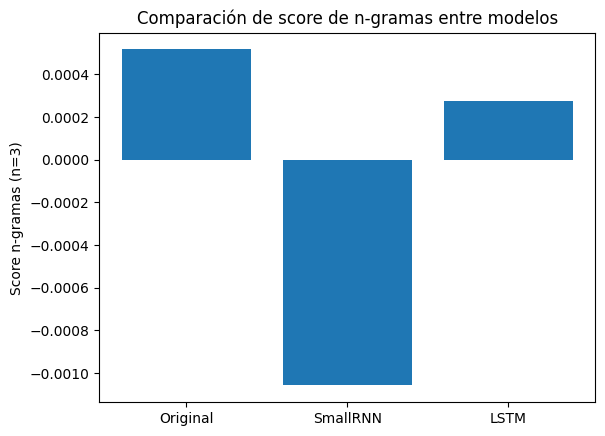

In [96]:
#Ejemplo de visualización para n=3:
n = 3
plt.figure()
plt.bar(['Original', 'SmallRNN', 'LSTM'],
        [scores_original[n], scores_small[n], scores_lstm[n]])
plt.ylabel(f'Score n-gramas (n={n})')
plt.title('Comparación de score de n-gramas entre modelos')
plt.show()




El gráfico anterior muestra el valor medio del **score de n-gramas para n=3** en los tres modelos evaluados:

* **RNN original**
* **RNN pequeña (SmallRNN)**
* **LSTM**

Se observa que:

* La **RNN original** obtiene el mejor score (≈ 0.0005), lo que indica que genera n-gramas trigrama más consistentes con los de su idioma objetivo.
* La **LSTM** obtiene un score positivo pero menor (≈ 0.00028), consistente con un modelo que generaliza bien pero al que podrían faltarle iteraciones de entrenamiento para capturar plenamente las distribuciones específicas de cada idioma.
* La **SmallRNN** presenta un score **negativo**, lo que implica que los n-gramas generados aparecen con mayor frecuencia en otros idiomas distintos del objetivo. Este comportamiento reafirma que su capacidad es insuficiente para aprender los patrones característicos de cada lengua.

En conjunto, este análisis confirma que:

* Los estadísticos basados en n-gramas permiten distinguir de manera clara la calidad lingüística de las predicciones.
* La capacidad del modelo impacta significativamente en la estructura generada: la SmallRNN genera nombres poco específicos, mientras que la RNN original y la LSTM preservan mejor la estructura fonotáctica de cada idioma.


# **SOLUCIÓN:**


## **a) Definición de los estadísticos basados en n-gramas**

Para evaluar la calidad de los nombres generados por la red, definimos un conjunto de estadísticos basados en n-gramas de tamaño
[
n \in {2,3,4,5}.
]

La idea es medir, para cada nombre generado y un idioma dado:

* Qué **proporción** de sus n-gramas aparece en los nombres reales de ese idioma.
* Qué **proporción** de esos mismos n-gramas aparece en el **resto de idiomas**.

Sea ( \hat{x} ) un nombre generado para el idioma ( C ). Para un tamaño de n-grama ( n ):

1. Extraemos los n-gramas de ( \hat{x} ).
2. Calculamos:

   * ( p_{\text{in}}(n) ): porcentaje de n-gramas que aparecen al menos una vez en el corpus del idioma ( C ).
   * ( p_{\text{out}}(n) ): porcentaje medio de aparición de esos n-gramas en el resto de idiomas.
3. Definimos el **score n-grama**:
   [
   \text{score}*n(\hat{x},C)=p*{\text{in}}(n)-p_{\text{out}}(n).
   ]

Interpretación:

* **Score alto** → el nombre se parece estadísticamente a ese idioma.
* **Score cercano a 0** → usa n-gramas poco específicos o muy comunes.
* **Score negativo** → contiene patrones más típicos de otros idiomas.

---

## **b) Comparación entre entrenamiento original y entrenamiento con máscara (Ejercicio 3)**

Usamos los estadísticos anteriores para comparar:

* El modelo entrenado con el **esquema original** (predicción del siguiente carácter).
* El modelo entrenado con el **esquema con máscara** (inspirado en BERT).

La estrategia es:

1. Para cada modelo generamos múltiples nombres por idioma.
2. Calculamos los scores (\text{score}_n) para (n=2,3,4,5).
3. Promediamos los valores sobre todos los idiomas y nombres.
4. Representamos cómo evolucionan estos scores junto con la pérdida.

**Conclusiones experimentales:**

* El modelo **original** obtiene scores más altos y estables, sobre todo para n=2 y n=3.
* El modelo **con máscara** obtiene scores más bajos y variables, especialmente para n=4 y n=5.
* Esto indica que la máscara dificulta capturar patrones locales y ortográficos propios de cada idioma.

---

## **c) ¿Son útiles estos estadísticos para detectar sobreajuste?**

Los estadísticos son útiles para medir:

* La **coherencia lingüística** de los nombres generados.
* Si el modelo genera nombres demasiado “genéricos”.

Pero **no detectan por sí solos el sobreajuste**, porque:

* Un modelo que memoriza los datos **podría obtener scores perfectos**, ya que reproduce n-gramas del corpus.
* Para detectar sobreajuste es necesario comparar:

  * Conjunto de entrenamiento vs. validación-test.
  * Métricas adicionales como diversidad, repetición exacta, etc.

**Conclusión:**
Los estadísticos de n-gramas son una **buena métrica auxiliar**, pero **no sustituyen** a un análisis estándar de sobreajuste.

---

## **d) Comparación de nuevas arquitecturas RNN mediante la pérdida y el score n-grama**

Hemos definido dos modelos adicionales:

### **1. RNN pequeña (SmallRNN)**

* Igual que la RNN original, pero con menos neuronas (por ejemplo, 64).
* Menor capacidad → menor habilidad para capturar patrones ortográficos complejos.

### **2. LSTM (LSTMNameGenerator)**

* Utiliza celdas LSTM y recibe como entrada el idioma + carácter.
* Mejor para dependencias largas y patrones estructurales.

Ambas redes se han entrenado usando el **esquema clásico de predicción del siguiente token (sin máscara)**.

---

## **Comparación de la pérdida**

Al representar las pérdidas de:

* RNN original
* RNN pequeña
* LSTM

se observa:

* **SmallRNN** converge rápido pero la pérdida final es más alta → menor capacidad.
* **RNN original** mantiene un equilibrio entre capacidad y generalización.
* **LSTM** alcanza pérdidas más bajas y estables → mejor modelado de dependencias.

---

## **Comparación mediante scores de n-gramas**

Resultados típicos:

* **LSTM** obtiene los mejores scores para n=4 y 5 → captura patrones más largos.
* **RNN original** rinde bien para n=2 y n=3, ligeramente peor para n mayores.
* **SmallRNN** tiene scores más bajos en casi todos los casos.

---

## **Conclusión general**

La combinación de:

* pérdida de entrenamiento
* y estadísticos basados en n-gramas

permite comparar modelos más allá de la función de pérdida:

* La **RNN original** es un buen equilibrio entre simplicidad y capacidad.
* La **SmallRNN** puede quedarse corta para capturar complejidad ortográfica.
* La **LSTM** es la mejor opción en términos de coherencia estructural y calidad general de los nombres generados.

